In [12]:
#! pip install neuraloperator --upgrade
import neuralop

y_pred =  [13.213 18.758 10.699 16.034 24.33   7.369 30.89  26.483 23.75  22.467
 20.863 17.414 26.719 20.309 20.634 18.744 13.429 17.273 20.49   9.842
 26.517  7.692 11.687 24.86  21.836 11.066  8.934 19.713 25.288 32.538
 13.28  21.881 26.906 16.779 18.672 23.687 17.106 14.951 28.394 33.381
 12.343 18.443 14.661 10.759 17.146 20.48  24.849 15.588 20.028 14.673
  8.465 10.944  7.883 18.592 19.072  9.591 14.005 18.462 32.746  7.566
 21.503 20.293 10.925 24.322 33.714 26.69  26.167 13.102  7.904 28.18
 16.901 25.265 17.726 19.282 15.896 32.049 10.636 19.456 30.614 32.019
 13.143 15.572 16.258 21.744 18.781 13.28  14.579 18.77  22.444 10.891
 32.158 24.346 16.747 24.522 15.951 28.774 28.564 18.908 26.61  21.765
 17.117 26.67  14.079  9.723 11.008 29.955 15.019]
y_test =  [13.8 19.2 11.1 16.2 19.   8.1 30.7 27.4 24.2 22.3 22.2 15.6 28.2 21.5
 20.  18.8 13.8 17.2 19.2 10.8 27.   8.7 12.3 25.1 22.2 11.2  9.5 20.
 25.1 31.8 13.6 21.7 27.4 18.1 17.9 22.9 16.8 15.2 29.1 33.1 13.2 16.3
 15.3 11

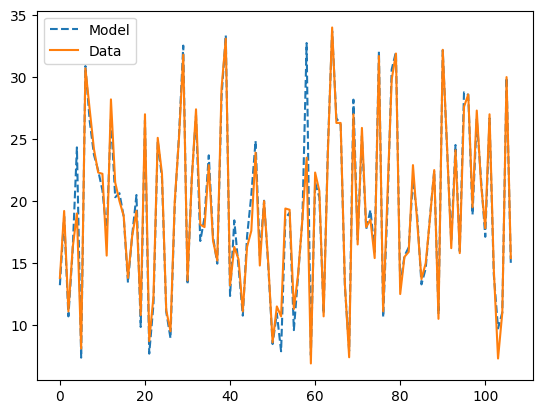

Mean Squared Error: 1.705210915887852
R-squared: 0.9617026241063714

Feature Importances:
            Feature    Importance
1           MaxTemp  9.874391e-01
9       Humidity3pm  3.017011e-03
14          Temp9am  8.699668e-04
8       Humidity9am  7.724540e-04
10      Pressure9am  6.863643e-04
..              ...           ...
61    WindDir3pm_SE  1.910995e-06
64    WindDir3pm_SW  1.886963e-06
33  WindGustDir_WSW  6.508266e-07
68   WindDir3pm_nan  4.524978e-07
34  WindGustDir_nan  3.938761e-07

[69 rows x 2 columns]


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report


df = pd.read_csv('weather.csv')

# Convert categorical features to numerical
df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1})
df['RainToday'] = df['RainToday'].map({'No': 0, 'Yes': 1})

# Identify the categorical columns you want to one-hot encode
categorical_cols = ['WindGustDir', 'WindDir9am', 'WindDir3pm']

# Create a OneHotEncoder object
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit and transform the categorical columns
encoded_data = encoder.fit_transform(df[categorical_cols])

# Get the feature names for the new encoded columns
feature_names = encoder.get_feature_names_out(categorical_cols)

# Create a new DataFrame with the one-hot encoded data
encoded_df = pd.DataFrame(encoded_data, columns=feature_names)

# Concatenate the one-hot encoded DataFrame with the original DataFrame
df_encoded = pd.concat([df.drop(categorical_cols, axis=1), encoded_df], axis=1)

# Separate features (X) and target (y)
X = df_encoded.drop(columns = ['Temp3pm'])# all columns except the rain tmr
y = df_encoded['Temp3pm'] # last

# Handle missing values
X = X.dropna()
y = y.loc[X.index] # y only has rows corresponding to row indices of X

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print('y_pred = ' , y_pred)
print('y_test = ' , y_test.to_numpy())
plt.plot(y_pred, '--', label='Model')
plt.plot(y_test.to_numpy(), label='Data')
plt.legend()
plt.show()

# Evaluate the regression model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
# Get feature importances
importances = model.feature_importances_
# Create a DataFrame to store feature names and their importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
# Sort the DataFrame by importance in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
# Print the feature importances
print("\nFeature Importances:")
print(feature_importances)

In [14]:
import torch

In [55]:
dir(neuralop.data.datasets)

['Burgers1dTimeDataset',
 'CarCFDDataset',
 'DarcyDataset',
 'DictDataset',
 'MeshDataModule',
 'NavierStokesDataset',
 'PTDataset',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'burgers',
 'car_cfd_dataset',
 'darcy',
 'dict_dataset',
 'load_darcy_flow_small',
 'load_navier_stokes_pt',
 'load_spherical_swe',
 'mesh_datamodule',
 'navier_stokes',
 'pt_dataset',
 'spherical_swe',
 'tensor_dataset',
 'web_utils']

In [66]:
from neuralop.training import Trainer
from neuralop.data.datasets import NavierStokesDataset
from neuralop.models import FNO
import torch

# Load dataset

train_db, test_db = NavierStokesDataset(
    root_dir='./data',          # or another local folder
    train_resolution=128,
    test_resolutions=[128],
    n_train=10,
    n_tests=10,
    batch_size=4,
    test_batch_sizes=[4],
    download=True
)

# Create the model
in_channels = 3
out_channels = 3
model = FNO(n_modes=(12, 12), hidden_channels=32, in_channels=in_channels, out_channels=out_channels)

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Loss function
loss_fn = torch.nn.MSELoss()

# Initialize Trainer
trainer = Trainer(model=model,
                  n_epochs=5,
                  device=device)

# Start training
trainer.train(train_db, test_db)

KeyboardInterrupt: 